<a href="https://colab.research.google.com/github/as791/Cat-vs-Dog/blob/master/Dog_vs_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/dogs-vs-cats')

Mounted at /content/drive


In [2]:
os.listdir()

['sampleSubmission.csv',
 'train',
 'test1',
 'X_train.npy',
 'Y_train.npy',
 'nn12.h5',
 'nn21.h5',
 'nn22.h5',
 'X_test.npy',
 'Y_pre.csv',
 'nn11.h5']

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

**Creating Data to Process**

In [0]:
mapping_label = {0:'cat',1:'dog'}

In [0]:
def img_label(img):
    word_label=img.split('.')[0]
    if word_label=='cat':
        return 0
    elif word_label=='dog':
        return 1

In [0]:
def create_train_data(path):
    X,Y=[],[]
    my_dir = os.listdir(path)
    for img in tqdm(my_dir):
        label=img_label(img)
        img_data = cv2.imread(path +'/'+img)
        interpolate = cv2.INTER_AREA
        if(img_data.shape[0]<80 or img_data.shape[1]<80):
            interpolate = cv2.INTER_LINEAR
        img_data = cv2.resize(img_data, (80, 80),interpolation=interpolate)
        X.append(img_data)
        Y.append(label)
    return X,Y

In [13]:
X_train,Y_train=create_train_data('./train')

100%|██████████| 25000/25000 [2:07:15<00:00,  3.75it/s]


In [0]:
X_train  = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [0]:
np.save('X_train.npy',X_train)
np.save('Y_train.npy',Y_train)

In [0]:
def create_test_data(path):
    X=[]
    my_dir = sorted(list(map(lambda x:int(x[:-4]),os.listdir(path))))
    for img in tqdm(my_dir):
        img_data = cv2.imread(path +'/'+ str(img) + '.jpg')
        interpolate = cv2.INTER_AREA
        if(img_data.shape[0]<80 or img_data.shape[1]<80):
            interpolate = cv2.INTER_LINEAR
        img_data = cv2.resize(img_data, (80, 80),interpolation=interpolate)
        X.append(img_data)
    return X

In [17]:
X_test = create_test_data('./test1')

100%|██████████| 12500/12500 [1:04:43<00:00,  3.76it/s]


In [0]:
X_test = np.asarray(X_test)

In [0]:
np.save('X_test.npy',X_test)

In [0]:
X_test.shape

(12500, 80, 80, 3)

**Loading Data and Preprocessing it and dividing it in test, train, validation set**

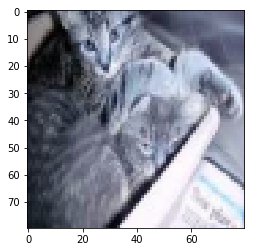

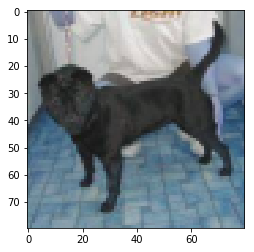

In [20]:
plt.imshow(X_train[100])
plt.show()
plt.imshow(X_test[150])
plt.show()

In [21]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train)

Using TensorFlow backend.


In [22]:
X_train.shape,Y_train.shape

((25000, 80, 80, 3), (25000, 2))

In [23]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',[0,1],np.argmax(Y_train,axis=1))
print(weights)

[1. 1.]


In [0]:
from keras.utils import normalize
X_train = normalize(X_train,axis=1)
X_test = normalize(X_test,axis=1)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train,Y_train = shuffle(X_train,Y_train,random_state = 2)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.2,random_state = 2)

In [26]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((20000, 80, 80, 3), (20000, 2), (5000, 80, 80, 3), (5000, 2))

**Proposed Models and training data on it**

In [0]:
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, regularizers, BatchNormalization, Input
import keras.optimizers as optimizers
import keras.callbacks as callbacks
from sklearn import metrics

In [51]:
input_= Input((80,80,3))
conv1  = Conv2D(64,3,padding='same',activation='relu')(input_)
pool1 = MaxPooling2D()(conv1)
norm1 = BatchNormalization()(pool1)
conv2  = Conv2D(64,3,padding='same',activation='relu')(norm1)
pool2 = MaxPooling2D()(conv2)
norm2 = BatchNormalization()(pool2)
conv3  = Conv2D(128,3,padding='same',activation='relu')(norm2)
pool3 = MaxPooling2D()(conv3)
norm3 = BatchNormalization()(pool3)
conv4  = Conv2D(256,3,padding='same',activation='relu')(norm3)
conv5  = Conv2D(256,3,padding='same',activation='relu')(conv4)
pool6 = MaxPooling2D()(conv5)
flat7 = Flatten()(pool6)
drop8 = Dropout(0.05)(flat7)
dense9 = Dense(128,activation='relu')(drop8)
dense10 = Dense(64,activation='relu')(dense9)
dense11 = Dense(2,activation='sigmoid')(dense10)

model = Model(inputs=input_,outputs=dense11)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 80, 80, 64)        1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 40, 40, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 40, 40, 64)        256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 20, 64)        256       
__________

In [0]:
model.compile(optimizer='nadam',loss='binary_crossentropy',metrics=['accuracy'])
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

In [53]:
history = model.fit(X_train,Y_train,epochs=25,batch_size=250,validation_data=(X_val,Y_val),callbacks=[lr_reduce])

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 22s 1ms/step - loss: 0.7161 - acc: 0.6356 - val_loss: 1.7632 - val_acc: 0.4964
Epoch 2/25
20000/20000 [==============================] - 20s 1ms/step - loss: 0.5328 - acc: 0.7346 - val_loss: 0.9693 - val_acc: 0.5206
Epoch 3/25
20000/20000 [==============================] - 20s 1ms/step - loss: 0.6393 - acc: 0.7113 - val_loss: 0.6865 - val_acc: 0.6116
Epoch 4/25
20000/20000 [==============================] - 20s 1ms/step - loss: 0.4406 - acc: 0.7926 - val_loss: 0.7911 - val_acc: 0.6265
Epoch 5/25
20000/20000 [==============================] - 20s 1ms/step - loss: 0.3687 - acc: 0.8358 - val_loss: 0.4717 - val_acc: 0.7775
Epoch 6/25
20000/20000 [==============================] - 20s 1ms/step - loss: 0.3046 - acc: 0.8706 - val_loss: 0.4967 - val_acc: 0.7542
Epoch 7/25
20000/20000 [==============================] - 20s 1ms/step - loss: 0.2604 - acc: 0.8883 - val_loss: 0.3813 - val_acc:

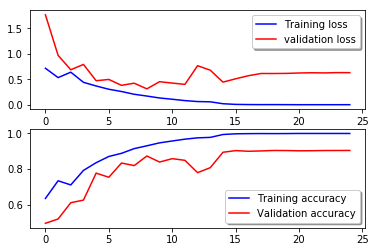

In [54]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [55]:
pred = model.predict(X_val)
Y_pred = np.argmax(pred,axis=1)
print(metrics.accuracy_score(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.log_loss(np.argmax(Y_val,axis=1),Y_pred))
print(metrics.classification_report(np.argmax(Y_val,axis=1),Y_pred))

0.9038
3.3226705889008894
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2531
           1       0.90      0.91      0.90      2469

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [0]:
pre = model.predict(X_test)   
Y_pre = np.argmax(pre,axis=1) 

dog [0.14727578 0.8634354 ] 0


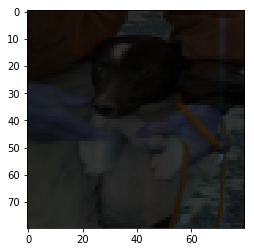

dog [0. 1.] 1


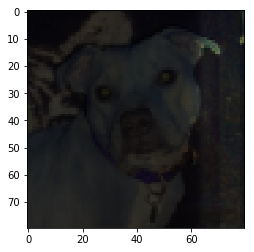

dog [3.2782555e-07 9.9999940e-01] 2


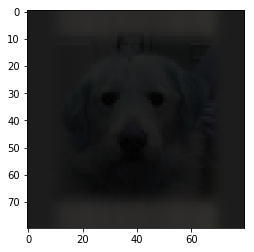

dog [7.4505806e-07 9.9999881e-01] 3


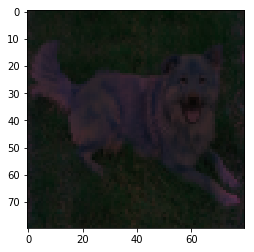

cat [9.9999642e-01 2.9802322e-06] 4


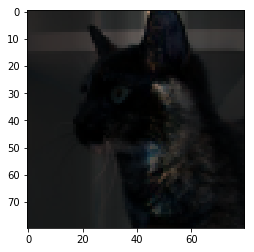

cat [9.9999988e-01 1.7881393e-07] 5


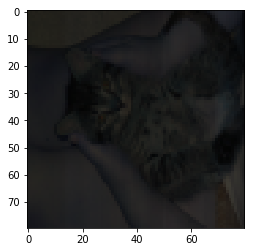

cat [1. 0.] 6


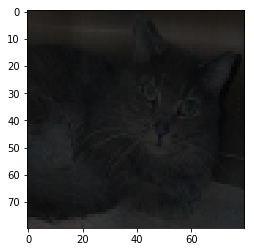

dog [3.9103627e-04 9.9958158e-01] 7


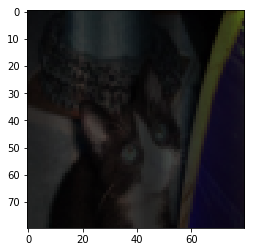

cat [9.9999976e-01 6.8545341e-07] 8


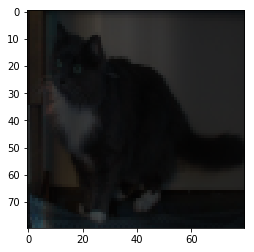

cat [9.9999732e-01 3.8444996e-06] 9


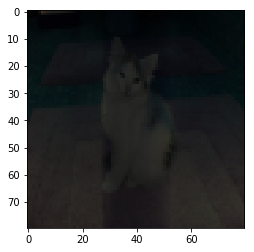

cat [1. 0.] 10


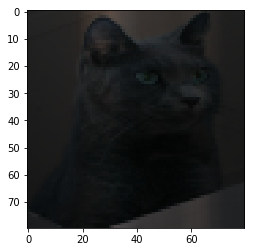

dog [6.2298775e-04 9.9942660e-01] 11


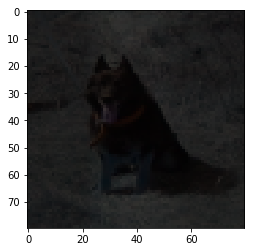

cat [9.9999988e-01 1.7881393e-07] 12


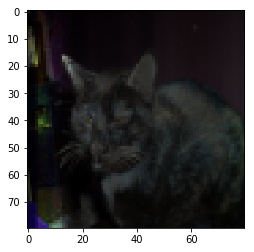

cat [9.999995e-01 5.662441e-07] 13


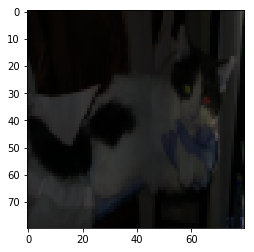

cat [1. 0.] 14


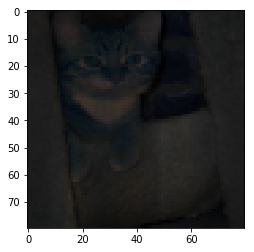

cat [9.997420e-01 4.208386e-04] 15


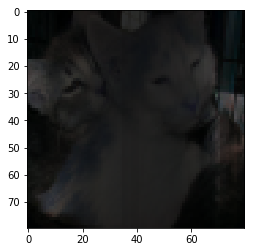

dog [0.01756763 0.97298723] 16


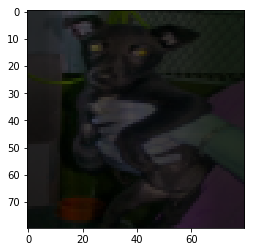

dog [1.4007092e-06 9.9999893e-01] 17


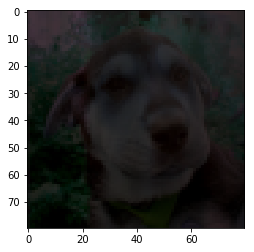

cat [9.999962e-01 4.619360e-06] 18


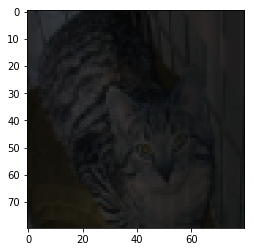

cat [1.0000000e+00 1.4901161e-07] 19


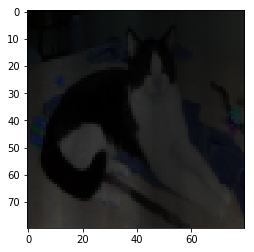

dog [1.9967556e-05 9.9997997e-01] 20


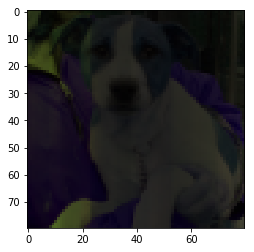

cat [9.9999994e-01 1.1920929e-07] 21


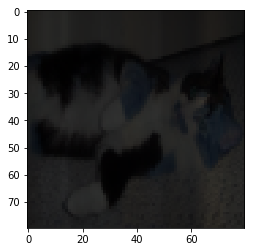

dog [1.1265278e-05 9.9998474e-01] 22


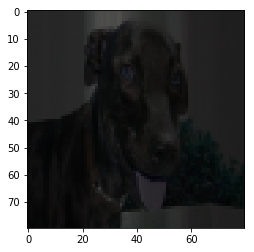

dog [1.6391277e-06 9.9999762e-01] 23


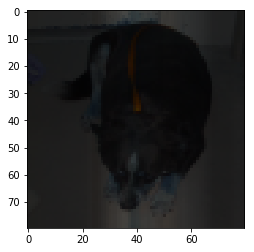

cat [0.84602475 0.19429445] 24


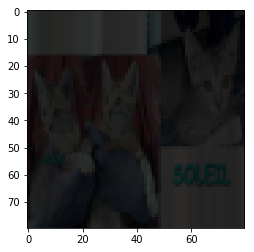

dog [7.0419908e-04 9.9912703e-01] 25


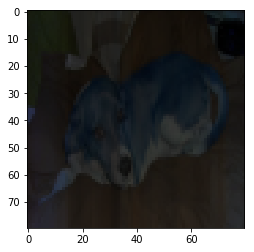

dog [4.172325e-07 9.999994e-01] 26


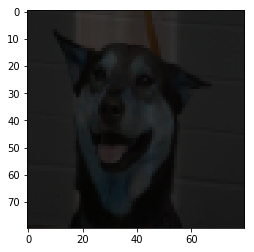

cat [1. 0.] 27


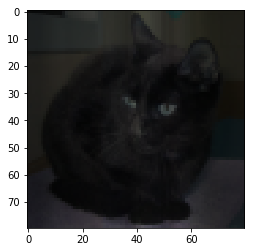

dog [0.01506254 0.979141  ] 28


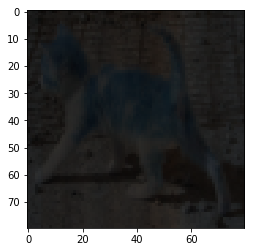

dog [3.5762787e-07 9.9999964e-01] 29


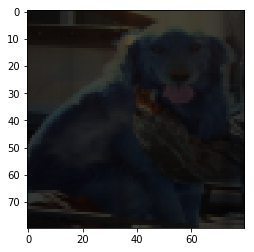

dog [2.9802322e-08 9.9999988e-01] 30


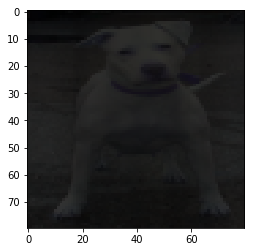

cat [9.9893165e-01 9.4318390e-04] 31


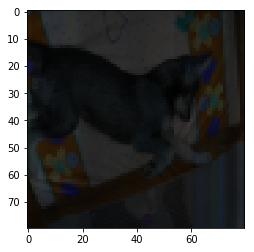

dog [8.690357e-05 9.998504e-01] 32


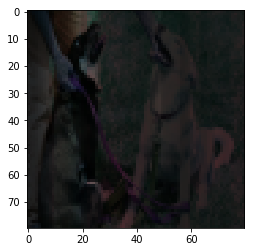

cat [9.9998653e-01 2.4020672e-05] 33


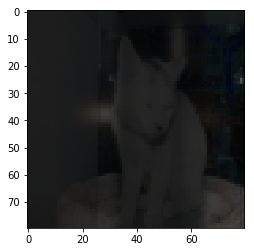

cat [9.9998534e-01 1.0192394e-05] 34


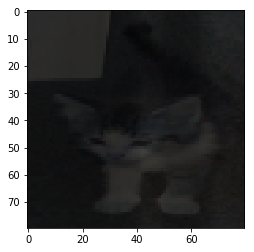

cat [9.9997354e-01 2.6434660e-05] 35


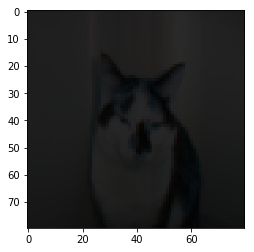

cat [1. 0.] 36


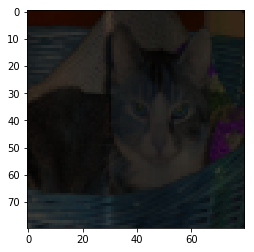

cat [1. 0.] 37


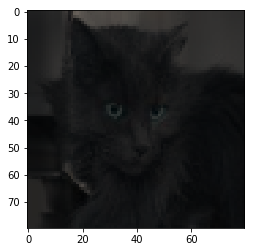

dog [2.4676323e-04 9.9978387e-01] 38


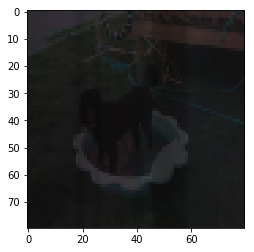

cat [9.9999785e-01 2.8312206e-06] 39


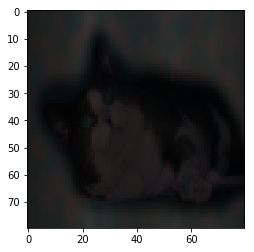

dog [0.18599519 0.81633735] 40


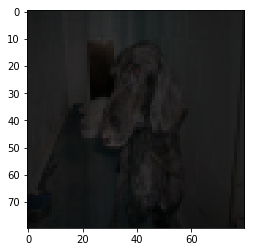

dog [0. 1.] 41


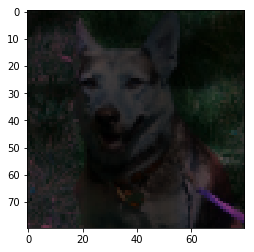

dog [0. 1.] 42


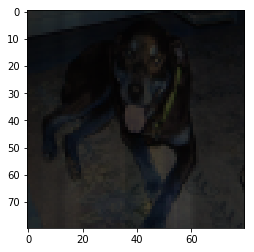

dog [4.5382977e-04 9.9944663e-01] 43


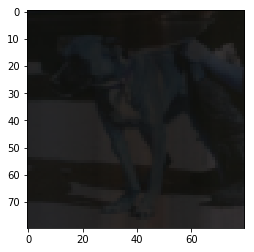

cat [9.9999881e-01 1.9967556e-06] 44


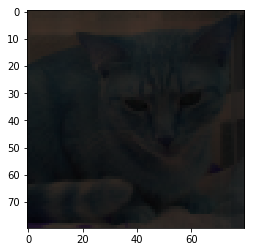

dog [0.00449947 0.9947654 ] 45


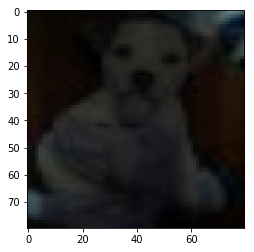

cat [1. 0.] 46


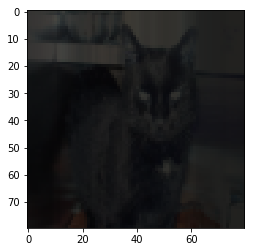

dog [5.7816505e-06 9.9999493e-01] 47


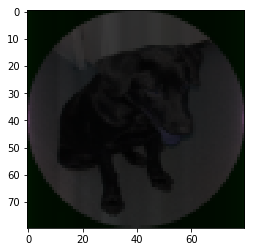

dog [5.9604645e-08 9.9999988e-01] 48


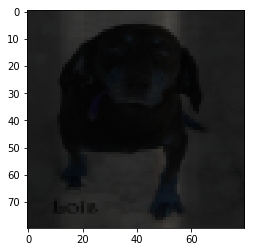

cat [9.9888170e-01 8.5681677e-04] 49


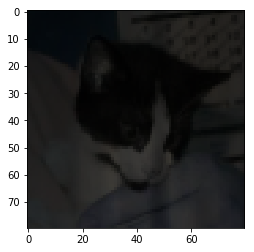

cat [0.9985322  0.00115585] 50


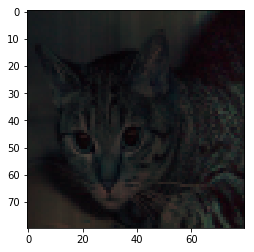

cat [9.9999917e-01 1.2814999e-06] 51


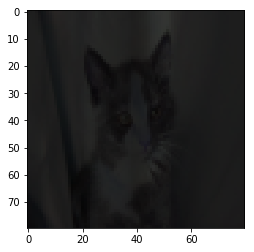

cat [0.9974566  0.00209916] 52


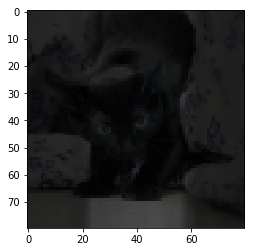

cat [9.999969e-01 6.943941e-06] 53


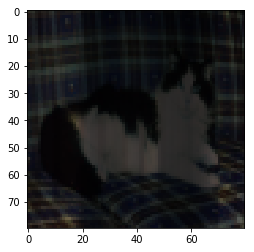

cat [0.92354715 0.04687527] 54


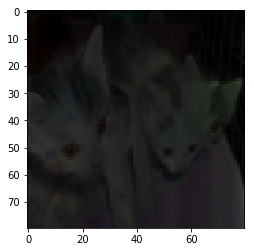

In [34]:
for i in range(55):
    plt.imshow(X_test[i])
    print(mapping_label[Y_pre[i]],pre[i],i)
    plt.show()

In [0]:
import pandas as pd
sub = pd.read_csv('sampleSubmission.csv')

In [0]:
sub.iloc[:,1]=Y_pre

In [0]:
sub.to_csv('Y_pre.csv')